In [2]:
#Imports
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical, Normal
import matplotlib.pyplot as plt
import time
import random

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [1]:
#Install dependencies
!pip install optuna
!apt-get update && apt-get install -y build-essential swig
!pip install -q optuna gymnasium[box2d] mujoco gymnasium-robotics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 12.3 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,077 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,811 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,276 kB]
Get:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:12 https://ppa.launchpadcontent.net/graphi

Installing system dependencies...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Installing Python packages...
Installation complete.

Using device: cuda
Global seed: 6


Running FINAL training for: CartPole-v1
--- Training for 50 epochs ---
Epoch: 1/50 | Avg Reward: 21.64 | Time: 3.83s
Epoch: 2/50 | Avg Reward: 67.73 | Time: 7.32s
Epoch: 3/50 | Avg Reward: 10.34 | Time: 10.95s
Epoch: 4/50 | Avg Reward: 23.19 | Time: 14.91s
Epoch: 5/50 | Avg Reward: 105.00 | Time: 18.42s
Epoch: 6/50 | Avg Reward: 15.02 | Time: 21.91s
Epoch: 7/50 | Avg Reward: 199.80 | Time: 25.95s
Epoch: 8/50 | Avg Reward: 145.59 | Time: 29.45s
Epoch: 9/50 | Avg Reward: 326.18 | Time: 32.95s
Epoch: 10/50 | Avg Reward: 15.54 | Time: 36.80s
Epoch: 11/50 | Avg Reward: 25.04 | Time: 40.47s
Epoch: 12/50 | Avg Reward: 68.12 | Time: 43.97s
Epoch: 13/50 | Avg Reward: 72.36 | Time: 47.54s

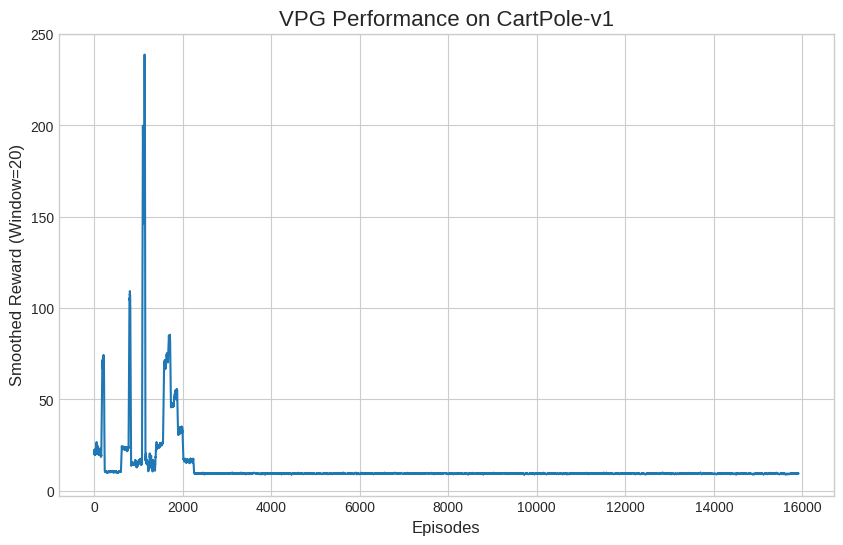

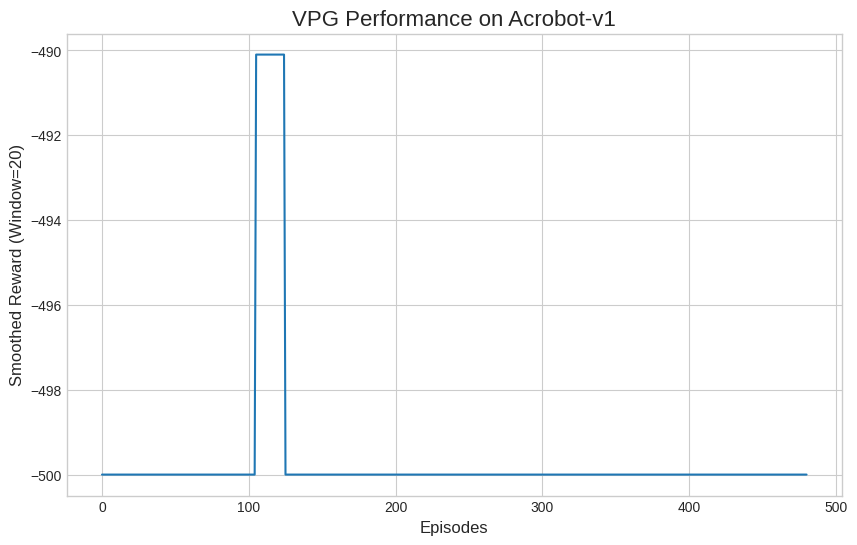

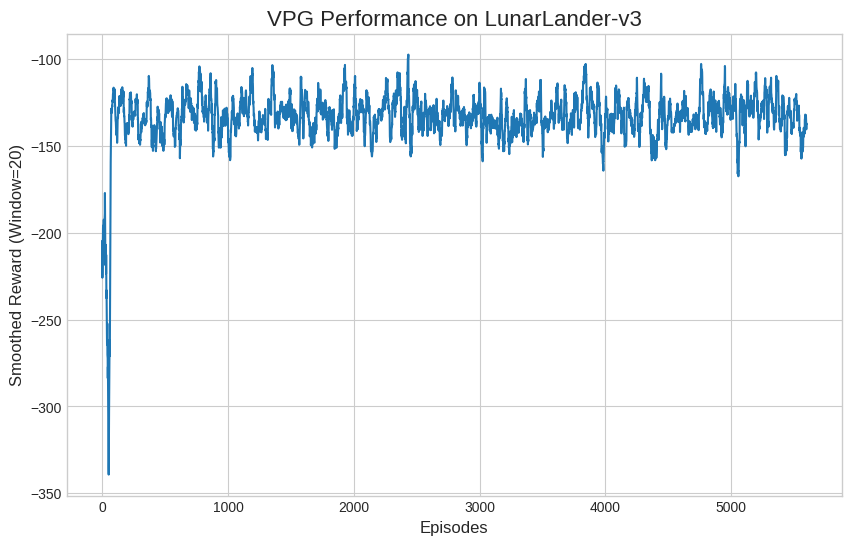

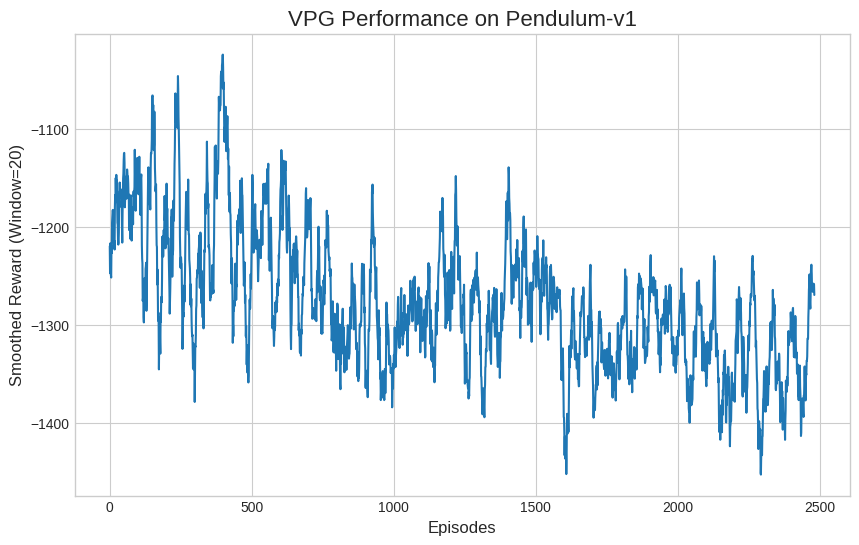

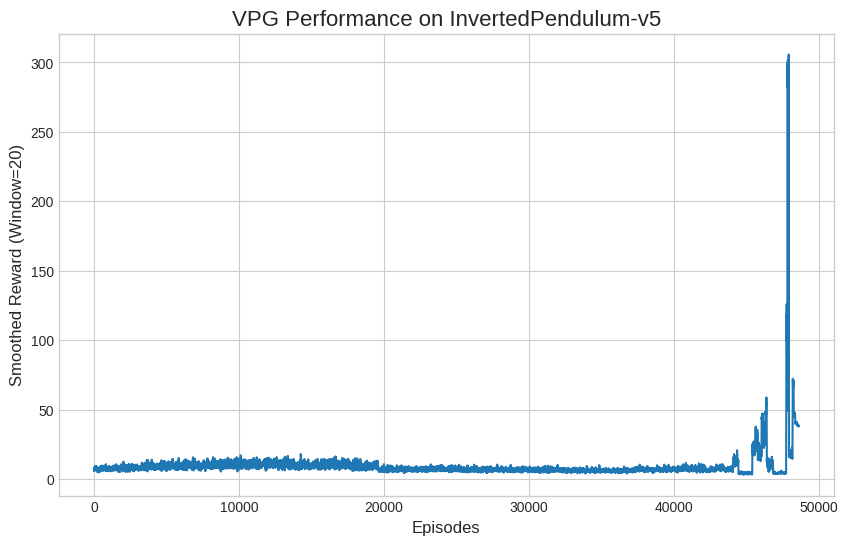

In [5]:

SEED = 6
# Defines the Actor-Critic neural network architecture.
# It uses shared layers for feature extraction and separate heads for the policy (actor) and value function (critic).
# The network can handle both continuous and discrete action spaces.
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, is_continuous):
        super(ActorCritic, self).__init__()
        self.is_continuous = is_continuous
        self.shared_layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh()
        )
        self.actor_head = nn.Linear(64, action_dim)
        self.critic_head = nn.Linear(64, 1)
        if is_continuous:
            self.log_std = nn.Parameter(torch.zeros(1, action_dim))

    def forward(self, state):
        shared_features = self.shared_layers(state)
        value = self.critic_head(shared_features)
        if self.is_continuous:
            mean = self.actor_head(shared_features)
            std = torch.exp(self.log_std)
            dist = Normal(mean, std)
        else:
            logits = self.actor_head(shared_features)
            dist = Categorical(logits=logits)
        return dist, value

# Calculates the Generalized Advantage Estimation (GAE) and returns for a batch of trajectories.
# GAE provides a fine-tuned balance between high-variance Monte Carlo estimates and high-bias TD estimates.
def compute_gae(rewards, values, dones, gamma, lambda_gae):
    advantages = []
    last_advantage = 0
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t+1] * (1 - dones[t]) - values[t]
        last_advantage = delta + gamma * lambda_gae * (1 - dones[t]) * last_advantage
        advantages.insert(0, last_advantage)

    advantages = torch.tensor(advantages, dtype=torch.float32).to(device)
    returns = advantages + torch.tensor(values[:-1], dtype=torch.float32).to(device)
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    return advantages, returns


# Main training loop for the Vanilla Policy Gradient (VPG) algorithm.
# It orchestrates data collection, advantage estimation, and policy/critic updates.
def train(config):
    seed = config["seed"]
    torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

    env = gym.make(config["env_name"])
    env.reset(seed=seed); env.action_space.seed(seed)
    state_dim = env.observation_space.shape[0]
    is_continuous = isinstance(env.action_space, gym.spaces.Box)
    action_dim = env.action_space.shape[0] if is_continuous else env.action_space.n

    agent = ActorCritic(state_dim, action_dim, is_continuous).to(device)
    optimizer = torch.optim.Adam(agent.parameters(), lr=config["lr"])

    start_time = time.time()
    all_episode_rewards = []

    print(f"--- Training for {config['epochs']} epochs ---")

    for epoch in range(config["epochs"]):
        batch_states, batch_actions, batch_rewards, batch_values, batch_dones = [], [], [], [], []
        ep_rewards_in_epoch = []
        steps_in_epoch = 0; state, _ = env.reset(); current_episode_reward = 0

        while steps_in_epoch < config["steps_per_epoch"]:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                dist, value = agent(state_tensor)
                action = dist.sample()
            action_np = action.cpu().numpy()[0]
            next_state, reward, terminated, truncated, _ = env.step(action_np)
            done = terminated or truncated
            batch_states.append(state_tensor); batch_actions.append(action); batch_rewards.append(reward)
            batch_values.append(value.cpu().item()); batch_dones.append(done)
            state = next_state; steps_in_epoch += 1; current_episode_reward += reward
            if done:
                all_episode_rewards.append(current_episode_reward)
                ep_rewards_in_epoch.append(current_episode_reward)
                state, _ = env.reset(); current_episode_reward = 0

        with torch.no_grad():
            _, last_value = agent(torch.FloatTensor(state).unsqueeze(0).to(device))
            batch_values.append(last_value.cpu().item())
        advantages, returns = compute_gae(batch_rewards, batch_values, batch_dones, config["gamma"], config["lambda_gae"])
        states_tensor = torch.cat(batch_states); actions_tensor = torch.cat(batch_actions)

        for _ in range(config["train_iters"]):
            dist, values = agent(states_tensor)
            log_probs = dist.log_prob(actions_tensor)
            policy_loss = -(log_probs * advantages).mean()
            value_loss = nn.MSELoss()(values.squeeze(), returns)
            loss = policy_loss + 0.5 * value_loss
            optimizer.zero_grad(); loss.backward(); optimizer.step()

        avg_reward = np.mean(ep_rewards_in_epoch) if ep_rewards_in_epoch else 0.0
        print(f"Epoch: {epoch+1}/{config['epochs']} | Avg Reward: {avg_reward:.2f} | Time: {time.time() - start_time:.2f}s")

    env.close()
    return all_episode_rewards

FINAL_VPG_CONFIGS = {
    "CartPole-v1": {
        "env_name": "CartPole-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 4000,
        "gamma": 0.99, "lambda_gae": 0.97, "lr": 0.004997, "train_iters": 68,
    },
    "Acrobot-v1": {
        "env_name": "Acrobot-v1", "seed": 6, "epochs": 50, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.95, "lr": 0.0005, "train_iters": 80,
    },
    "LunarLander-v3": {
        "env_name": "LunarLander-v3", "seed": 6, "epochs": 100, "steps_per_epoch": 4000,
        "gamma": 0.99, "lambda_gae": 0.95, "lr": 0.001084, "train_iters": 42,
    },
    "Pendulum-v1": {
        "env_name": "Pendulum-v1", "seed": 6, "epochs": 100, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.95, "lr": 0.000103, "train_iters": 38,
    },
    "InvertedPendulum-v5": {
        "env_name": "InvertedPendulum-v5", "seed": 6, "epochs": 100, "steps_per_epoch": 5000,
        "gamma": 0.99, "lambda_gae": 0.95, "lr": 0.000765, "train_iters": 76,
    }
}

environments_to_run = [
    "CartPole-v1",
    "Acrobot-v1",
    "LunarLander-v3",
    "Pendulum-v1",
    "InvertedPendulum-v5"
]

all_results = {}

for env_name in environments_to_run:
    print(f"\n\n{'='*20}\nRunning FINAL training for: {env_name}\n{'='*20}")
    rewards = train(FINAL_VPG_CONFIGS[env_name])
    all_results[env_name] = rewards

# Plotting function
def moving_average(data, window_size):
    if len(data) < window_size: return np.array([])
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

print("\n\n--- Plotting Final Results ---")

for env_name, rewards in all_results.items():
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-whitegrid')

    smoothed_rewards = moving_average(rewards, 20)
    if smoothed_rewards.any():
        plt.plot(smoothed_rewards)

    plt.title(f"VPG Performance on {env_name}", fontsize=16)
    plt.xlabel("Episodes", fontsize=12)
    plt.ylabel("Smoothed Reward (Window=20)", fontsize=12)
    plt.grid(True)
    plt.show()

In [ ]:
# #HyperParameter tuning(already incorporated the optimal hyperparameters for each environment in the last cell)



# def objective(trial, env_name):
#     config = {
#         "env_name": env_name, "seed": SEED, "epochs": 20, "steps_per_epoch": 2000,
#         "gamma": 0.99, "lambda_gae": 0.97,
#         "lr": trial.suggest_float("lr", 1e-4, 5e-3, log=True),
#         "train_iters": trial.suggest_int("train_iters", 10, 80),
#     }

#     # Setup environment and agent
#     torch.manual_seed(config["seed"]); np.random.seed(config["seed"]); random.seed(config["seed"])
#     env = gym.make(config["env_name"])
#     env.reset(seed=config["seed"]); env.action_space.seed(config["seed"])

#     state_dim = env.observation_space.shape[0]
#     is_continuous = isinstance(env.action_space, gym.spaces.Box)
#     action_dim = env.action_space.shape[0] if is_continuous else env.action_space.n

#     agent = ActorCritic(state_dim, action_dim, is_continuous).to(device)
#     optimizer = torch.optim.Adam(agent.parameters(), lr=config["lr"])

#     # Training loop INSIDE the objective function for pruning
#     for epoch in range(config["epochs"]):
#         # Data Collection
#         batch_states, batch_actions, batch_rewards, batch_values, batch_dones = [], [], [], [], []
#         ep_rewards_in_epoch = []
#         steps_in_epoch = 0; state, _ = env.reset(); current_episode_reward = 0
#         while steps_in_epoch < config["steps_per_epoch"]:
#             with torch.no_grad():
#                 state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
#                 dist, value = agent(state_tensor)
#                 action = dist.sample()
#             action_np = action.cpu().numpy()[0]
#             next_state, reward, terminated, truncated, _ = env.step(action_np)
#             done = terminated or truncated
#             batch_states.append(state_tensor); batch_actions.append(action); batch_rewards.append(reward)
#             batch_values.append(value.cpu().item()); batch_dones.append(done)
#             state = next_state; steps_in_epoch += 1; current_episode_reward += reward
#             if done:
#                 ep_rewards_in_epoch.append(current_episode_reward)
#                 state, _ = env.reset(); current_episode_reward = 0

#         # GAE and Update
#         with torch.no_grad():
#             _, last_value = agent(torch.FloatTensor(state).unsqueeze(0).to(device))
#             batch_values.append(last_value.cpu().item())
#         advantages, returns = compute_gae(batch_rewards, batch_values, batch_dones, config["gamma"], config["lambda_gae"])
#         states_tensor = torch.cat(batch_states); actions_tensor = torch.cat(batch_actions)
#         for _ in range(config["train_iters"]):
#             dist, values = agent(states_tensor)
#             log_probs = dist.log_prob(actions_tensor)
#             policy_loss = -(log_probs * advantages).mean()
#             value_loss = nn.MSELoss()(values.squeeze(), returns)
#             loss = policy_loss + 0.5 * value_loss
#             optimizer.zero_grad(); loss.backward(); optimizer.step()

#         # Pruning Logic
#         avg_reward = np.mean(ep_rewards_in_epoch) if ep_rewards_in_epoch else -np.inf
#         trial.report(avg_reward, epoch)
#         if trial.should_prune():
#             env.close()
#             raise optuna.exceptions.TrialPruned()

#     env.close()
#     return np.mean(ep_rewards_in_epoch) if ep_rewards_in_epoch else -np.inf

# environments_to_run = [
#     "CartPole-v1",
#     "Acrobot-v1",
#     "LunarLander-v3",
#     "Pendulum-v1",
#     "InvertedPendulum-v2"
# ]

# all_best_params = {}
# n_trials_per_env = 30

# for env_name in environments_to_run:
#     print(f"\n\n{'='*20}\nOptimizing for: {env_name}\n{'='*20}")

#     # We use a lambda function to pass the env_name to the objective
#     study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
#     study.optimize(lambda trial: objective(trial, env_name), n_trials=n_trials_per_env, timeout=3600)

#     print(f"\n--- Optimization Finished for {env_name} ---")
#     print(f"Best score: {study.best_value:.2f}")
#     print("Best parameters found:")
#     for key, value in study.best_params.items():
#         print(f"    {key}: {value}")

#     all_best_params[env_name] = study.best_params

# print(f"\n\n{'='*20}\nALL OPTIMIZATIONS COMPLETE\n{'='*20}")
# print("Final tuned hyperparameters for all environments:")
# for env_name, params in all_best_params.items():
#     print(f"\n--- {env_name} ---")
#     print(params)